In [4]:
#!pip install catboost

In [5]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/aiffel/house/real

Mounted at /content/drive
/content/drive/MyDrive/aiffel/house/real


In [6]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
train = pd.read_csv('./train.csv')
test =  pd.read_csv('./test.csv')
print(train.info(), train.shape)
print(test.info(), test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [8]:
y = train['price']
train_X = train.drop(['price'], axis=1)

print(train_X.head())

   id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  20141013T000000         3       1.00         1180      5650     1.0   
1   1  20150225T000000         2       1.00          770     10000     1.0   
2   2  20150218T000000         3       2.00         1680      8080     1.0   
3   3  20140627T000000         3       2.25         1715      6819     2.0   
4   4  20150115T000000         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   
3           0     0          3      7        1715              0      1995   
4           0     0          3      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqf

In [9]:
data = pd.concat((train_X,test), axis = 0)

<Axes: >

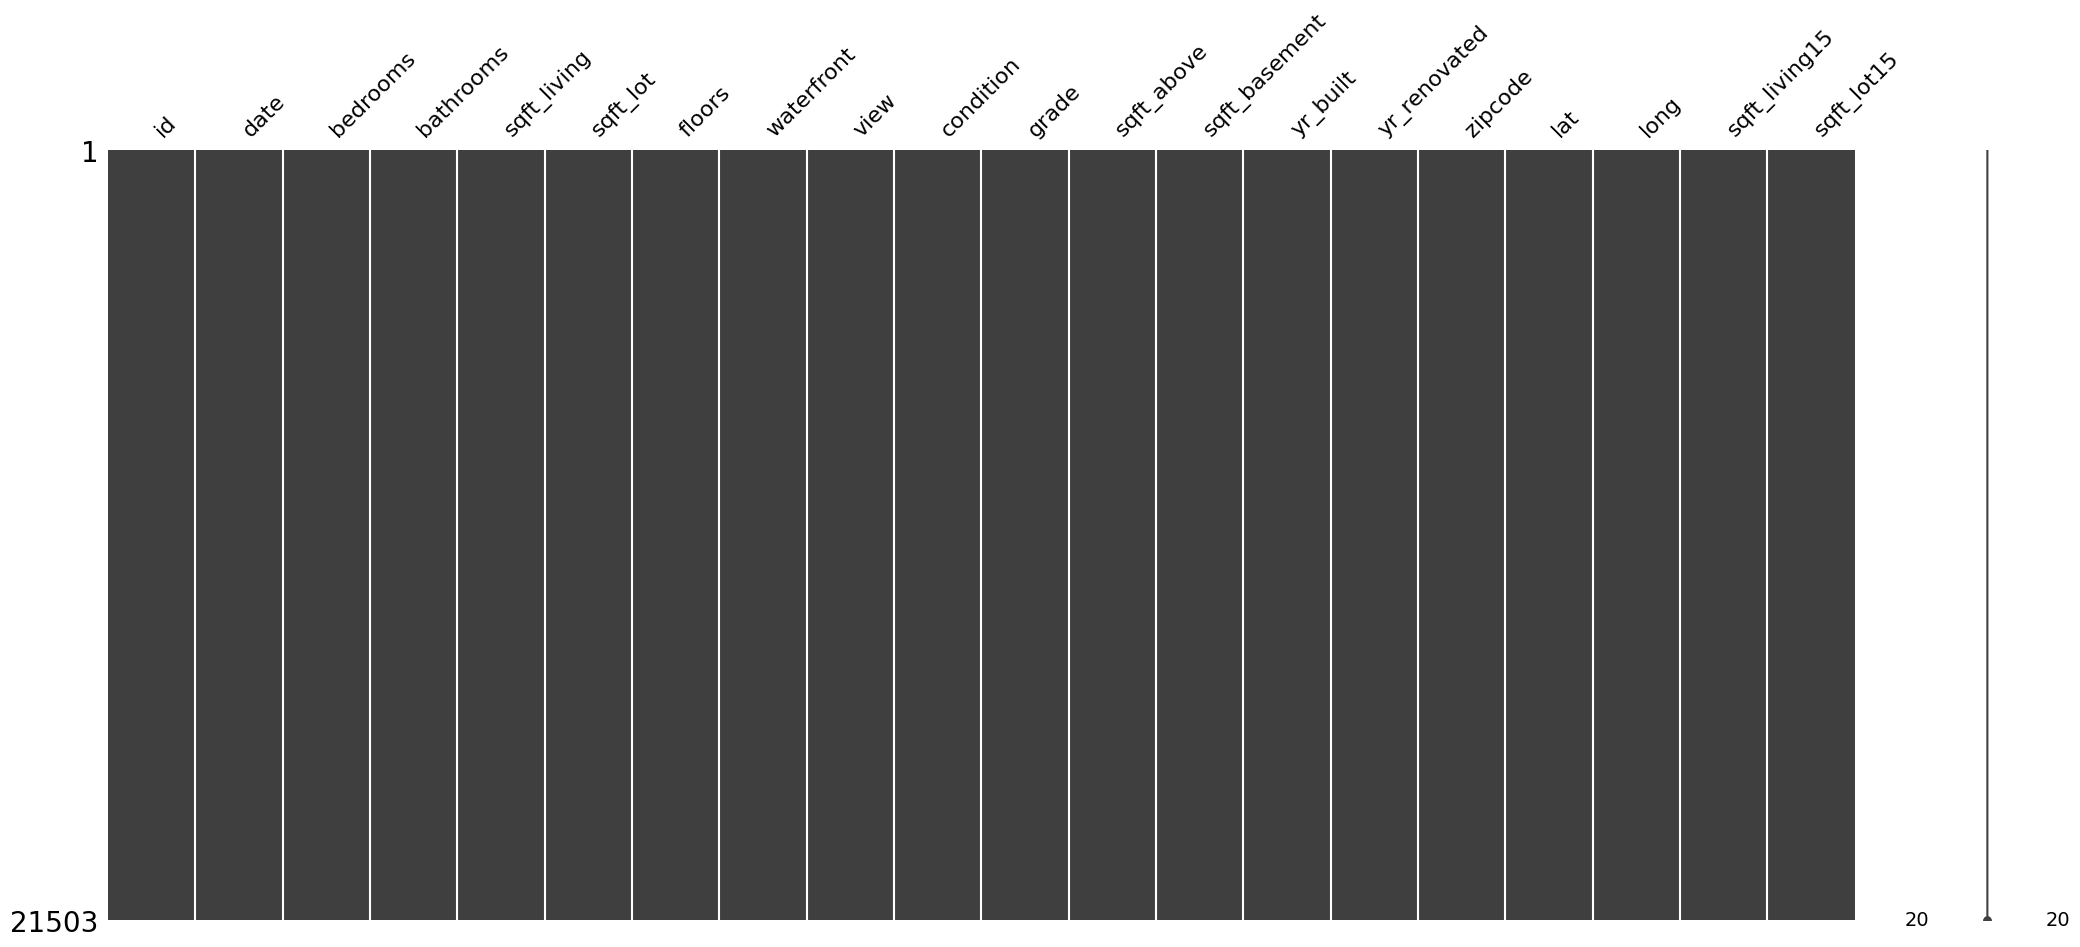

In [10]:
msno.matrix(data)

In [11]:
for col in data.columns :
  print('{} : {}'.format(col, len(data.loc[pd.isnull(data[col]), col].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [12]:
test_id = data['id'][len(train):]
del data['id']



In [13]:
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)

In [14]:
print(data)

        date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0     201410         3       1.00         1180      5650     1.0           0   
1     201502         2       1.00          770     10000     1.0           0   
2     201502         3       2.00         1680      8080     1.0           0   
3     201406         3       2.25         1715      6819     2.0           0   
4     201501         3       1.50         1060      9711     1.0           0   
...      ...       ...        ...          ...       ...     ...         ...   
6463  201406         3       1.75         1500     11968     1.0           0   
6464  201501         3       2.00         1490      1126     3.0           0   
6465  201502         3       2.50         1310      1294     2.0           0   
6466  201406         2       0.75         1020      1350     2.0           0   
6467  201501         3       2.50         1600      2388     2.0           0   

      view  condition  grade  sqft_abov

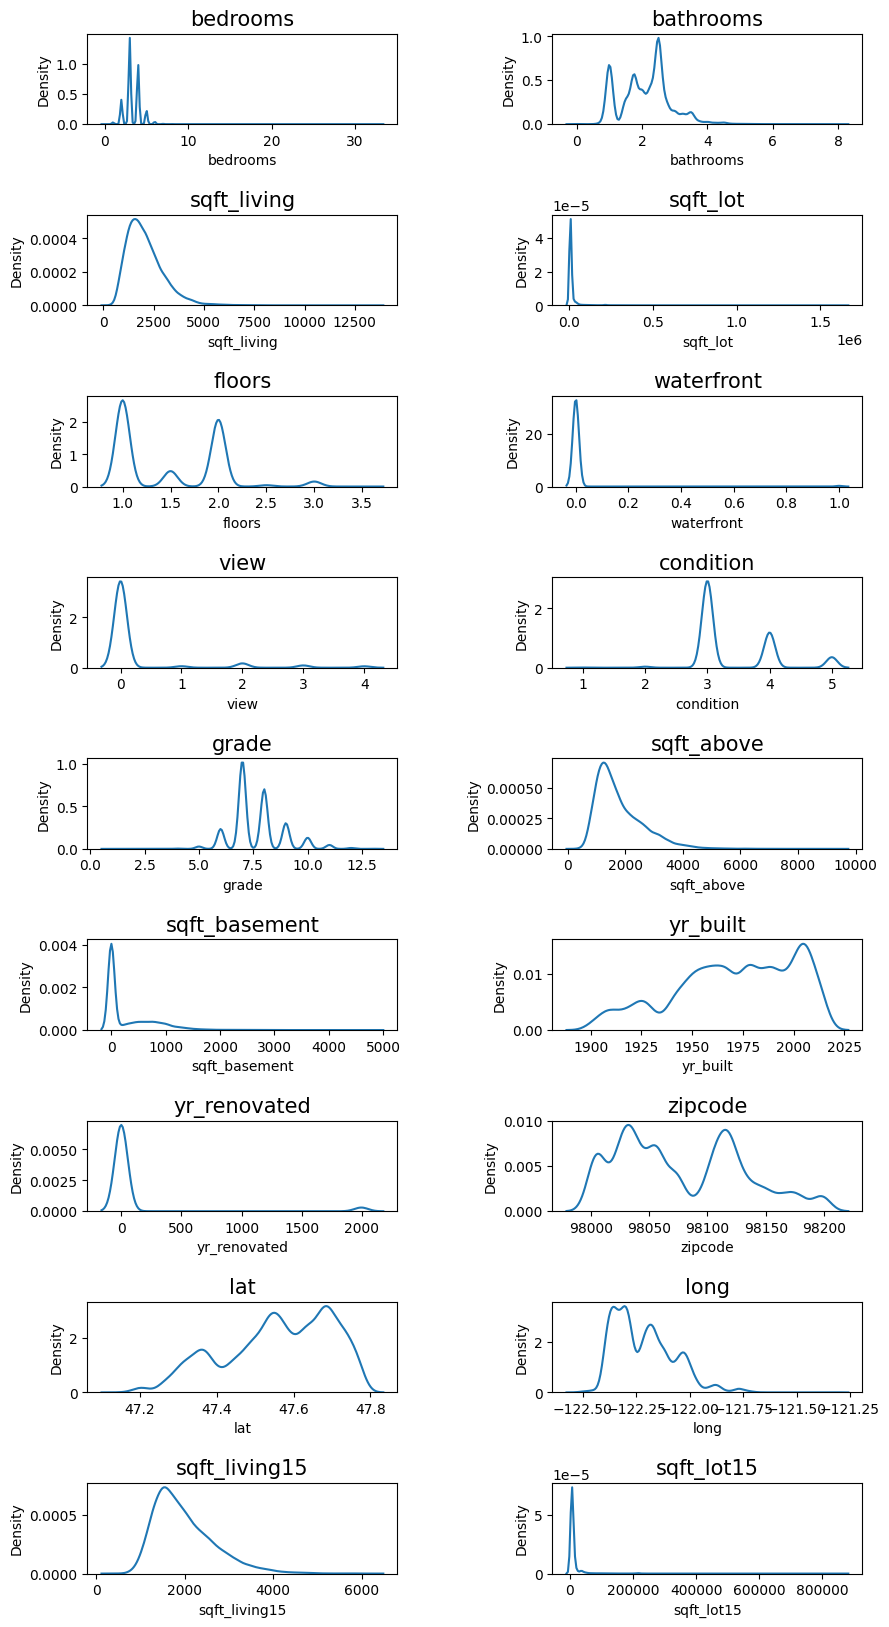

In [15]:
def distribution(df, col=1):
  row = int(df.shape[1] / col)

  count = 1
  columns = df.columns

  fig, ax = plt.subplots(row, col, figsize=(10,20))
  for i in range(row):
    for j in range(col):
      sns.kdeplot(data=df[columns[count]], ax=ax[i][j])
      ax[i][j].set_title(columns[count], fontsize=15)
      count += 1
      if count == df.shape[1]:
        break
  plt.subplots_adjust(wspace=0.5, hspace=1)

distribution(data, col=2)

In [16]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

def log_scaling(data, skew_columns):
  for c in skew_columns:
    data[c] = np.log1p(data[c].values)
  return data

log_scaling(data, skew_columns)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,1.386294,1.75,7.313887,9.390075,1.0,0,0,3,6,7.313887,0.000000,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,1.386294,2.00,7.307202,7.027315,3.0,0,0,3,8,7.307202,0.000000,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,1.386294,2.50,7.178545,7.166266,2.0,0,0,3,8,7.074117,4.875197,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,1.098612,0.75,6.928538,7.208600,2.0,0,0,3,7,6.928538,0.000000,2009,0,98144,47.5944,-122.299,1020,2007


# modeling

In [49]:
df_test = data.iloc[len(train):, :]
df_train = data.iloc[:len(train), :]

In [18]:
y = np.log1p(y)

In [19]:
def rmse(y_test, y_pred):
  return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [20]:
random_state = 2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [21]:
def get_scores(models, train, y):
  df = {}

  for model in models :
    model_name = model.__class__.__name__

    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size =0.2, random_state=random_state)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    df[model_name] =rmse(y_test,y_pred)
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

  return score_df

get_scores(models, df_train, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.047779


,RMSE
GradientBoostingRegressor,128360.173766
RandomForestRegressor,125189.780635
XGBRegressor,117618.223445
LGBMRegressor,111906.947718


In [22]:
def gs_result(model, train, y, param_grid, verbose=2, n_jobs=5):

    grid_model = GridSearchCV(
        model, param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5, verbose=verbose, n_jobs=n_jobs)

    grid_model.fit(train, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score

    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [23]:
param_grid = { "max_depth" : [-1],
"learning_rate" : [0.1], \
"n_estimators" : [100,200 ], \
"num_leaves" : [40], \
"reg_lambda" : [25,50,75]
#"boosting_type" : ["gbdt"]

}

model = lightgbm
gs_result(model, df_train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


,learning_rate,max_depth,n_estimators,num_leaves,reg_lambda,score,RMSLE
4,0.1,-1,200,40,50,-0.025932,0.161034
3,0.1,-1,200,40,25,-0.025954,0.161101
5,0.1,-1,200,40,75,-0.026129,0.161646
0,0.1,-1,100,40,25,-0.026728,0.163486
1,0.1,-1,100,40,50,-0.026915,0.164057
2,0.1,-1,100,40,75,-0.027349,0.165375


In [24]:
random_state = 2020
max_depth = -1
learning_rate= 0.1
n_estimators = 200
num_leaves = 40
reg_lambda = 50

light = LGBMRegressor(max_depth = max_depth,learning_rate = learning_rate,\
                      n_estimators = n_estimators, num_leaves=num_leaves,\
                      reg_lambda=reg_lambda,random_state=random_state)

models = [light]
get_scores(models, df_train, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.047779


,RMSE
LGBMRegressor,106053.352081


In [25]:
model = LGBMRegressor(max_depth = -1, n_estimators=200, num_leaves = 40, reg_lambda = 50, random_state=random_state)
model.fit(df_train, y)
prediction = model.predict(df_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


In [26]:
prediction = np.expm1(prediction)

In [27]:
submission = pd.read_csv('./sample_submission.csv')

In [28]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.933965e+05
1,15036,4.920200e+05
2,15037,1.395279e+06
3,15038,3.197904e+05
4,15039,3.279866e+05


In [29]:
submission_csv_path = ('./submission_lgbm_RMSLE_1.csv')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

./submission_lgbm_RMSLE_1.csv


### 여기서 부턴 궁금증

In [31]:
random_state = 2020
max_depth = -1
learning_rate= 0.1
n_estimators = 200
num_leaves = 40
reg_lambda = 50

catboost = cat.CatBoostRegressor(random_state=random_state)

models = [catboost]
get_scores(models, df_train, y)

Learning rate set to 0.060653
0:	learn: 0.5062202	total: 51.3ms	remaining: 51.3s
1:	learn: 0.4854645	total: 55.4ms	remaining: 27.7s
2:	learn: 0.4659590	total: 59.5ms	remaining: 19.8s
3:	learn: 0.4488925	total: 63.4ms	remaining: 15.8s
4:	learn: 0.4329194	total: 67.9ms	remaining: 13.5s
5:	learn: 0.4172880	total: 78.1ms	remaining: 12.9s
6:	learn: 0.4025015	total: 88.2ms	remaining: 12.5s
7:	learn: 0.3895396	total: 98.9ms	remaining: 12.3s
8:	learn: 0.3767851	total: 110ms	remaining: 12.1s
9:	learn: 0.3655364	total: 117ms	remaining: 11.6s
10:	learn: 0.3544014	total: 123ms	remaining: 11.1s
11:	learn: 0.3443803	total: 127ms	remaining: 10.4s
12:	learn: 0.3349603	total: 133ms	remaining: 10.1s
13:	learn: 0.3262822	total: 138ms	remaining: 9.75s
14:	learn: 0.3182424	total: 146ms	remaining: 9.57s
15:	learn: 0.3098078	total: 153ms	remaining: 9.39s
16:	learn: 0.3027732	total: 158ms	remaining: 9.14s
17:	learn: 0.2957720	total: 164ms	remaining: 8.92s
18:	learn: 0.2896175	total: 169ms	remaining: 8.73s
19:

,RMSE
CatBoostRegressor,101097.038792


In [32]:
model = cat.CatBoostRegressor(random_state=random_state)
model.fit(df_train, y)
prediction = model.predict(df_test)

Learning rate set to 0.062829
0:	learn: 0.5047794	total: 5.2ms	remaining: 5.19s
1:	learn: 0.4832992	total: 9.88ms	remaining: 4.93s
2:	learn: 0.4635128	total: 14.2ms	remaining: 4.72s
3:	learn: 0.4456791	total: 18.4ms	remaining: 4.58s
4:	learn: 0.4293209	total: 22.7ms	remaining: 4.52s
5:	learn: 0.4138420	total: 26.8ms	remaining: 4.45s
6:	learn: 0.3986828	total: 31.3ms	remaining: 4.44s
7:	learn: 0.3853833	total: 35.9ms	remaining: 4.46s
8:	learn: 0.3725419	total: 40.2ms	remaining: 4.43s
9:	learn: 0.3608479	total: 44.7ms	remaining: 4.42s
10:	learn: 0.3493522	total: 48.9ms	remaining: 4.39s
11:	learn: 0.3393739	total: 53.2ms	remaining: 4.38s
12:	learn: 0.3296478	total: 58.1ms	remaining: 4.41s
13:	learn: 0.3208951	total: 62.8ms	remaining: 4.42s
14:	learn: 0.3128455	total: 67.5ms	remaining: 4.43s
15:	learn: 0.3045295	total: 72.4ms	remaining: 4.45s
16:	learn: 0.2970537	total: 76.9ms	remaining: 4.45s
17:	learn: 0.2901487	total: 81.4ms	remaining: 4.44s
18:	learn: 0.2840269	total: 86ms	remaining: 4

In [33]:
prediction = np.expm1(prediction)

In [34]:
submission = pd.read_csv('./sample_submission.csv')

In [35]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.224029e+05
1,15036,4.825733e+05
2,15037,1.357922e+06
3,15038,3.051954e+05
4,15039,3.219182e+05


In [36]:
submission_csv_path = ('./submission_lgbm_RMSLE_2.csv')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

./submission_lgbm_RMSLE_2.csv


---


# 회고

전처리도 해보고 모델도 많이 바꿔봤지만 11만의 벽을 넘을수가 없었다.

주말에라도 도전해서 1300만 더 낮춰봐야 할 것 같다.

그래도 많은 사람들의 코드도 보고 작성해보면서 캐글 데이터 분석도 해볼 수 있겠다는 생각이 들었다.

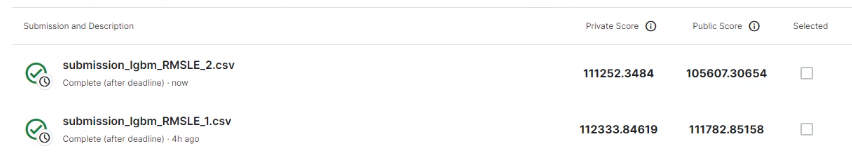